In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import random
import os

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

In [18]:
class MelodyDataset(Dataset):
    def __init__(self, sequences, seq_len=32):
        self.sequences = sequences
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if len(seq) > self.seq_len:
            start = random.randint(0, len(seq) - self.seq_len)
            seq = seq[start:start + self.seq_len]
        elif len(seq) < self.seq_len:
            # Pad with zeros
            padding = np.zeros((self.seq_len - len(seq), 4))
            seq = np.vstack([seq, padding])
        
        x = torch.FloatTensor(seq[:-1])  # Input sequence
        y = torch.FloatTensor(seq[1:])   # Target sequence (shifted by 1)
        return x, y

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [20]:
class MelodyTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=256, nhead=8, num_layers=6, seq_len=32):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, x, mask=None):
        x = self.input_proj(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.transformer(x, mask=mask)
        return self.output_proj(x)

In [21]:
def preprocess_data(raw_data, seq_len=32):
    """Preprocess raw melody data"""
    print(f"Raw data shape: {np.array(raw_data).shape}")
    
    # Convert to numpy array
    data = np.array(raw_data, dtype=np.float32)
    
    # Normalize features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences from continuous melody data
    sequences = []
    step_size = seq_len // 4  # Overlap sequences for more training data
    
    for i in range(0, len(data_scaled) - seq_len + 1, step_size):
        seq = data_scaled[i:i + seq_len]
        sequences.append(seq)
    
    print(f"Created {len(sequences)} sequences of length {seq_len}")
    
    # Visualize data distribution
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 3, 1)
    plt.hist(data[:, 0], bins=50, alpha=0.7)
    plt.title('Note Distribution')
    plt.xlabel('Note Value')
    
    plt.subplot(2, 3, 2)
    plt.hist(data[:, 1], bins=50, alpha=0.7)
    plt.title('Start Time Distribution')
    plt.xlabel('Start Time')
    
    plt.subplot(2, 3, 3)
    plt.hist(data[:, 2], bins=50, alpha=0.7)
    plt.title('End Time Distribution')
    plt.xlabel('End Time')
    
    plt.subplot(2, 3, 4)
    plt.hist(data[:, 3], bins=50, alpha=0.7)
    plt.title('Velocity Distribution')
    plt.xlabel('Velocity')
    
    plt.subplot(2, 3, 5)
    plt.hist(data[:, 2] - data[:, 1], bins=50, alpha=0.7)
    plt.title('Note Duration Distribution')
    plt.xlabel('Duration')
    
    plt.subplot(2, 3, 6)
    plt.scatter(data[:, 0], data[:, 3], alpha=0.5, s=1)
    plt.title('Note vs Velocity')
    plt.xlabel('Note')
    plt.ylabel('Velocity')
    
    plt.tight_layout()
    plt.show()
    
    return sequences, scaler

In [22]:
def musical_loss(pred, target, note_weight=2.0, time_weight=1.0, velocity_weight=0.5):
    """Custom loss function emphasizing musical coherence"""
    # Separate components
    note_loss = nn.functional.mse_loss(pred[:, :, 0], target[:, :, 0])
    start_loss = nn.functional.mse_loss(pred[:, :, 1], target[:, :, 1])
    end_loss = nn.functional.mse_loss(pred[:, :, 2], target[:, :, 2])
    velocity_loss = nn.functional.mse_loss(pred[:, :, 3], target[:, :, 3])
    
    # Duration consistency loss
    pred_duration = pred[:, :, 2] - pred[:, :, 1]
    target_duration = target[:, :, 2] - target[:, :, 1]
    duration_loss = nn.functional.mse_loss(pred_duration, target_duration)
    
    return (note_weight * note_loss + 
            time_weight * (start_loss + end_loss) + 
            velocity_weight * velocity_loss + 
            duration_loss)

In [23]:
def calculate_music_metrics(pred, target):
    """Calculate music-specific metrics"""
    with torch.no_grad():
        # Note accuracy (within semitone)
        note_acc = (torch.abs(pred[:, :, 0] - target[:, :, 0]) < 0.5).float().mean()
        
        # Timing accuracy (within 0.1 time units)
        time_acc = (torch.abs(pred[:, :, 1:3] - target[:, :, 1:3]) < 0.1).float().mean()
        
        # Velocity accuracy (within 10 units)
        vel_acc = (torch.abs(pred[:, :, 3] - target[:, :, 3]) < 0.1).float().mean()
        
        # Melodic smoothness (penalize large jumps)
        pred_intervals = torch.abs(pred[:, 1:, 0] - pred[:, :-1, 0])
        smoothness = torch.exp(-pred_intervals.mean())
        
    return {
        'note_accuracy': note_acc.item(),
        'timing_accuracy': time_acc.item(), 
        'velocity_accuracy': vel_acc.item(),
        'melodic_smoothness': smoothness.item()
    }

In [24]:
def train_model(model, train_loader, epochs=100, lr=1e-4):
    """Train the transformer model"""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    
    model.train()
    losses = []
    metrics_history = {'note_acc': [], 'time_acc': [], 'vel_acc': [], 'smoothness': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_metrics = {'note_accuracy': 0, 'timing_accuracy': 0, 
                        'velocity_accuracy': 0, 'melodic_smoothness': 0}
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = musical_loss(pred, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Calculate metrics
            batch_metrics = calculate_music_metrics(pred, batch_y)
            for key in epoch_metrics:
                epoch_metrics[key] += batch_metrics[key]
        
        scheduler.step()
        
        # Average metrics
        num_batches = len(train_loader)
        epoch_loss /= num_batches
        for key in epoch_metrics:
            epoch_metrics[key] /= num_batches
            
        losses.append(epoch_loss)
        metrics_history['note_acc'].append(epoch_metrics['note_accuracy'])
        metrics_history['time_acc'].append(epoch_metrics['timing_accuracy'])
        metrics_history['vel_acc'].append(epoch_metrics['velocity_accuracy'])
        metrics_history['smoothness'].append(epoch_metrics['melodic_smoothness'])
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss={epoch_loss:.4f}, '
                  f'Note Acc={epoch_metrics["note_accuracy"]:.3f}, '
                  f'Smoothness={epoch_metrics["melodic_smoothness"]:.3f}')
    
    # Visualize training progress
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(metrics_history['note_acc'])
    plt.title('Note Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(2, 3, 3)
    plt.plot(metrics_history['time_acc'])
    plt.title('Timing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(2, 3, 4)
    plt.plot(metrics_history['vel_acc'])
    plt.title('Velocity Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(2, 3, 5)
    plt.plot(metrics_history['smoothness'])
    plt.title('Melodic Smoothness')
    plt.xlabel('Epoch')
    plt.ylabel('Smoothness')
    
    plt.subplot(2, 3, 6)
    plt.plot(losses, label='Loss')
    plt.plot([x*10 for x in metrics_history['note_acc']], label='Note Acc (x10)')
    plt.title('Loss vs Note Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

In [32]:
def generate_melody(model, scaler, seed_sequence=None, length=64, temperature=0.8):
    """Generate new melody sequence"""
    model.eval()
    
    if seed_sequence is None:
        # Random seed
        generated = torch.randn(1, 1, 4).to(device)
    else:
        # Use provided seed
        seed_normalized = scaler.transform(np.array(seed_sequence))
        generated = torch.FloatTensor(seed_normalized).unsqueeze(0).to(device)
    
    with torch.no_grad():
        for _ in range(length - generated.size(1)):
            # Get prediction for next note
            pred = model(generated)
            next_note = pred[:, -1:, :] / temperature
            
            # Add some randomness for creativity
            next_note += torch.randn_like(next_note) * 0.1
            
            generated = torch.cat([generated, next_note], dim=1)
    
    # Convert back to original scale
    generated_np = generated.squeeze(0).cpu().numpy()
    generated_original = scaler.inverse_transform(generated_np)
    
    # Ensure musical constraints
    generated_original[:, 0] = np.clip(np.round(generated_original[:, 0]), 0, 127).astype(int)  # MIDI note range (int)
    generated_original[:, 1] = np.round(np.maximum(0, generated_original[:, 1]), 2)    # Start time >= 0 (2 decimals)
    generated_original[:, 2] = np.round(np.maximum(generated_original[:, 1] + 0.01, 
                                         generated_original[:, 2]), 2)        # End > start (2 decimals)
    generated_original[:, 3] = np.clip(np.round(generated_original[:, 3]), 0, 127).astype(int)  # Velocity range (int)
    
    return generated_original.tolist()

In [26]:
def train_melody_generator(raw_data, seq_len=32, epochs=100):
    """Complete training pipeline"""
    print("Starting melody generation training...")
    
    # Preprocess data
    sequences, scaler = preprocess_data(raw_data, seq_len)
    
    # Create dataset and dataloader
    dataset = MelodyDataset(sequences, seq_len)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, 
                            num_workers=4, pin_memory=True)
    
    # Create model
    model = MelodyTransformer(seq_len=seq_len).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    model = train_model(model, train_loader, epochs)
    
    return model, scaler


In [27]:
def load_data(instrument):
    with open(f'raw_data/{instrument}.json', 'r') as file:
        data = json.load(file)
        if isinstance(data, list):
            return data
        raise ValueError("JSON does not contain a top-level array.")

In [42]:
def save_data(array, filename=None):
    if not isinstance(array, list):
        raise ValueError("Input must be a list (array)")

    os.makedirs('generated_data', exist_ok=True)

    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"data_{timestamp}.json"

    path = os.path.join('generated_data', f'{filename}.json')

    with open(path, 'w') as file:
        json.dump(array, file, indent=2)

    print(f"Data saved to {path}")

Starting melody generation training...
Raw data shape: (17111, 4)
Created 2135 sequences of length 32


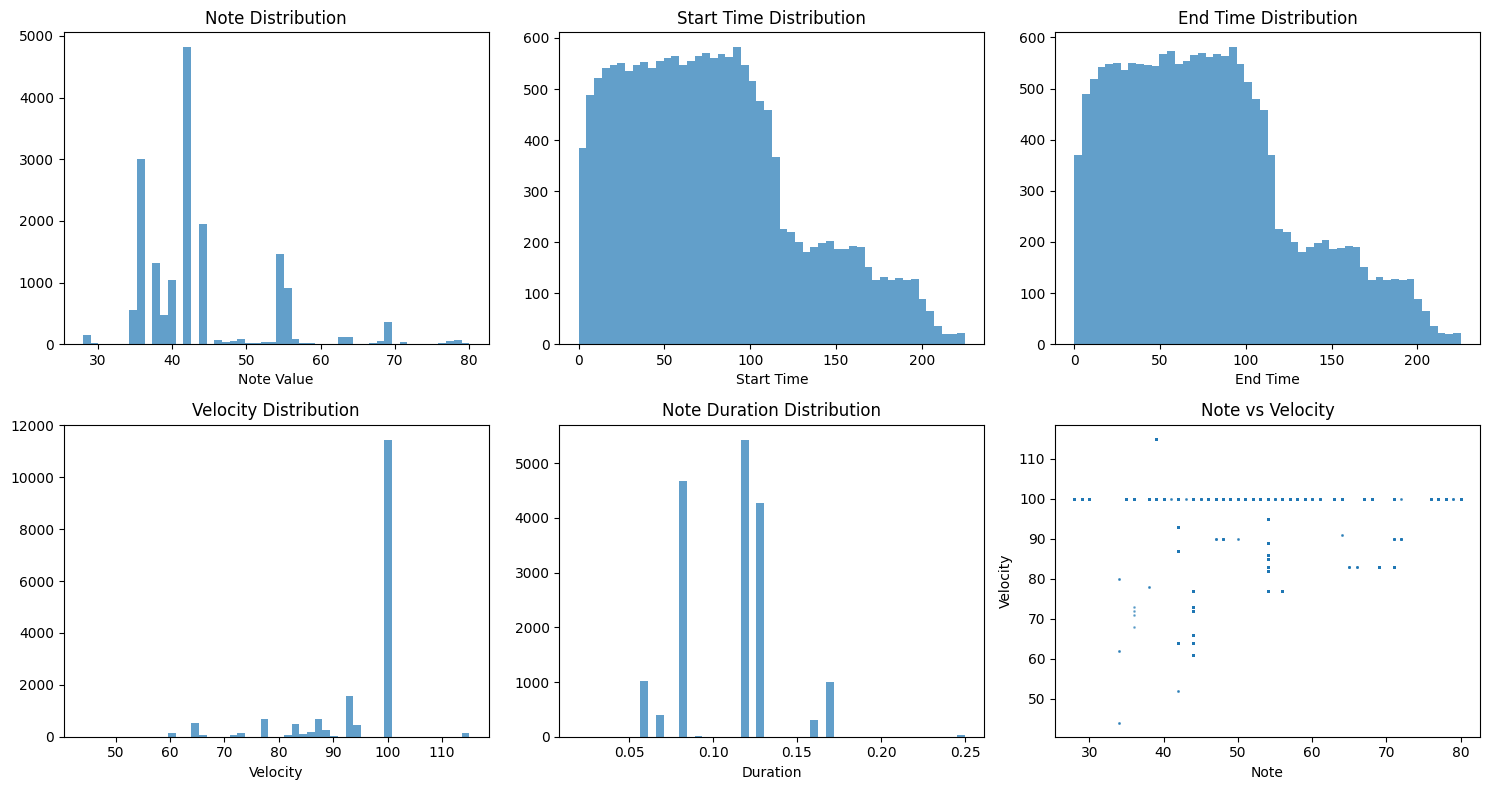

Model parameters: 4,740,868
Epoch 0: Loss=2.1227, Note Acc=0.549, Smoothness=0.887
Epoch 10: Loss=0.0937, Note Acc=0.985, Smoothness=0.431
Epoch 20: Loss=0.0659, Note Acc=0.988, Smoothness=0.430
Epoch 30: Loss=0.0484, Note Acc=0.991, Smoothness=0.429
Epoch 40: Loss=0.0359, Note Acc=0.993, Smoothness=0.429
Epoch 50: Loss=0.0304, Note Acc=0.995, Smoothness=0.429
Epoch 60: Loss=0.0246, Note Acc=0.996, Smoothness=0.429
Epoch 70: Loss=0.0225, Note Acc=0.996, Smoothness=0.429
Epoch 80: Loss=0.0192, Note Acc=0.997, Smoothness=0.429
Epoch 90: Loss=0.0188, Note Acc=0.997, Smoothness=0.430


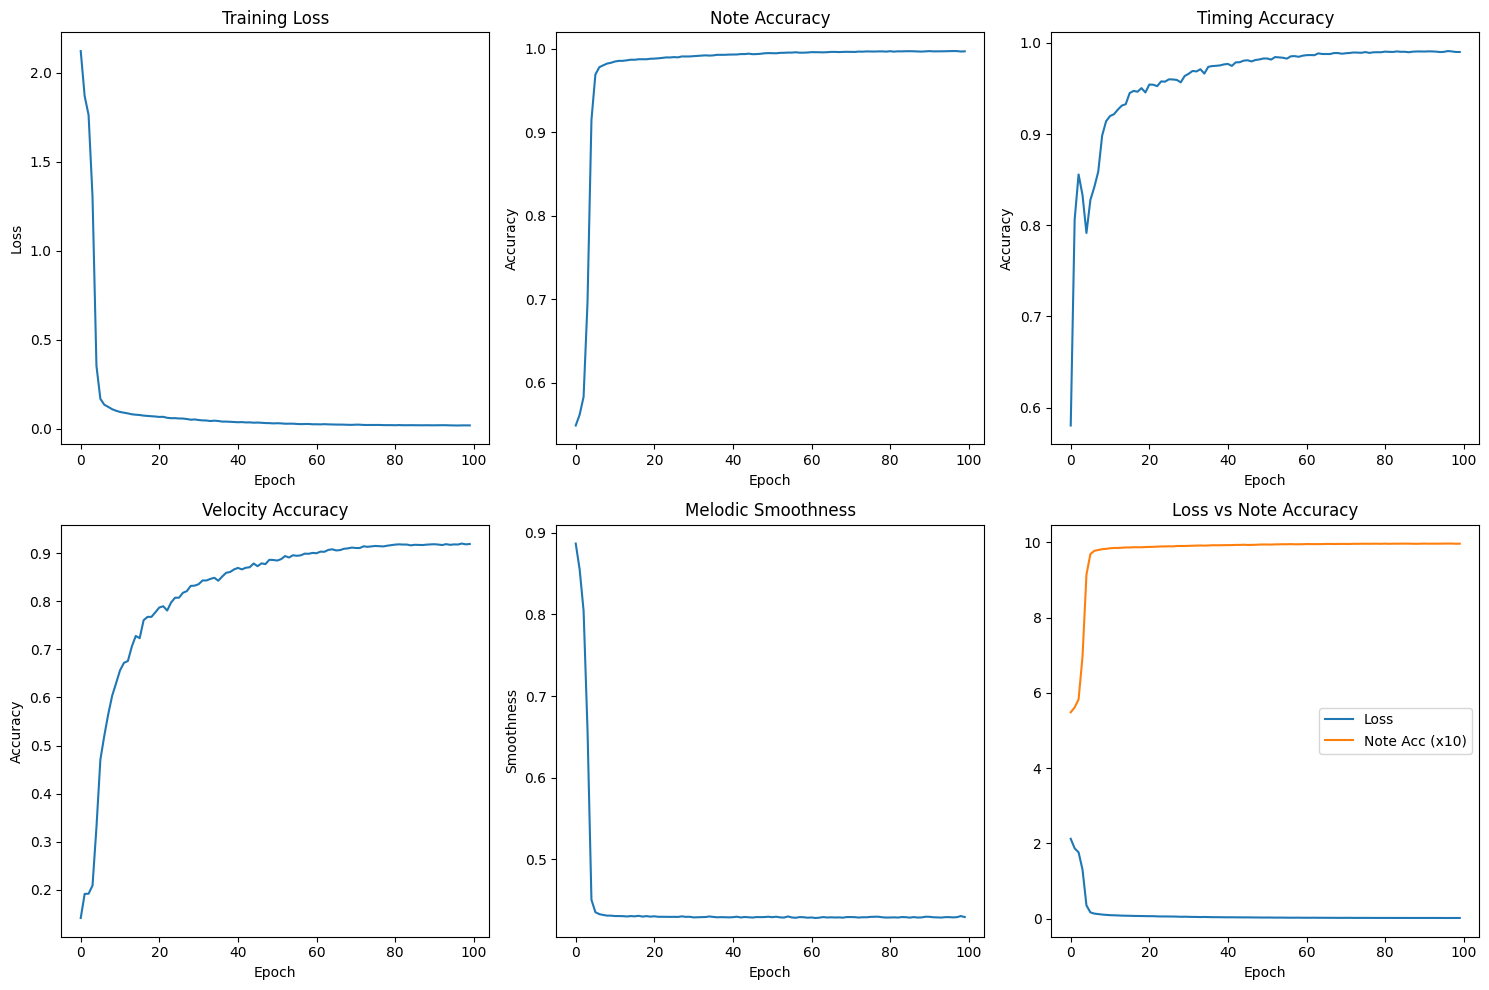

In [28]:
instrument = 24
raw_data = load_data(instrument)
model, scaler = train_melody_generator(raw_data, seq_len=32, epochs=100)

In [36]:
generated_melody = generate_melody(model, scaler, length=64, temperature=0.8)

In [43]:
save_data(generated_melody, '24')

Data saved to generated_data/24.json
